In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout, Input
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import VGG16


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout

import numpy as np
from tensorflow.keras.preprocessing import image

from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt

import cv2





In [2]:
print(tf.__version__)
# Print TensorFlow version
print("TensorFlow version:", tf.__version__)

# Check for GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("Num GPUs Available: ", len(gpus))
    print("GPU details:", gpus)
else:
    print("No GPU detected. Ensure CUDA and cuDNN are properly installed.")

2.10.0
TensorFlow version: 2.10.0
Num GPUs Available:  1
GPU details: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
test = cv2.imread( 'dataset/data_0312_params_1015_102_088_101/walls_normal/negative/negative_2.jpg')


[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


In [49]:
import os

def crop_non_black_area(image_path, save_path):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Image not found or cannot be loaded: {image_path}")
        return

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Find all non-black pixels
    coords = cv2.findNonZero(gray)  # Returns [[x, y]]
    if coords is None:
        print(f"No non-black pixels found in image: {image_path}")
        return

    # Get the bounding box
    x, y, w, h = cv2.boundingRect(coords)

    # Crop the image using the bounding box
    cropped_image = image[y:y+h, x:x+w]

    # Save the cropped image to the specified path
    os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Ensure the output directory exists
    cv2.imwrite(save_path, cropped_image)
    print(f"Cropped image saved to: {save_path}")

def process_folder(source_folder, target_folder):
    # Iterate over all image files in the source folder
    for filename in os.listdir(source_folder):
        # Construct full input and output file paths
        input_path = os.path.join(source_folder, filename)
        output_path = os.path.join(target_folder, filename)

        # Process the image
        crop_non_black_area(input_path, output_path)

# Example usage
image_type = 'negative'
source_folder = f"dataset/data_0912_diffrent_params_Rhenus_riss/walls_normal/{image_type}/"  # Source directory
target_folder = f"dataset/data_0912_diffrent_params_Rhenus_riss_preprocessed/walls_normal/{image_type}/"  # Target directory
process_folder(source_folder, target_folder)



Cropped image saved to: dataset/data_0912_diffrent_params_Rhenus_riss_preprocessed/walls_normal/negative/negative_1.jpg
Cropped image saved to: dataset/data_0912_diffrent_params_Rhenus_riss_preprocessed/walls_normal/negative/negative_10.jpg
Cropped image saved to: dataset/data_0912_diffrent_params_Rhenus_riss_preprocessed/walls_normal/negative/negative_100.jpg
Cropped image saved to: dataset/data_0912_diffrent_params_Rhenus_riss_preprocessed/walls_normal/negative/negative_101.jpg
Cropped image saved to: dataset/data_0912_diffrent_params_Rhenus_riss_preprocessed/walls_normal/negative/negative_102.jpg
Cropped image saved to: dataset/data_0912_diffrent_params_Rhenus_riss_preprocessed/walls_normal/negative/negative_103.jpg
Cropped image saved to: dataset/data_0912_diffrent_params_Rhenus_riss_preprocessed/walls_normal/negative/negative_104.jpg
Cropped image saved to: dataset/data_0912_diffrent_params_Rhenus_riss_preprocessed/walls_normal/negative/negative_105.jpg
Cropped image saved to: dat

In [50]:
#load and preprocess data
train_dir = 'dataset/data_0912_diffrent_params_Rhenus_riss_preprocessed/walls_normal/'


img_height, img_width = 299,299
batch_size = 10

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2,
    rotation_range = 20,
    #width_shift_range = 0.2,
   # height_shift_range = 0.2,
    #shear_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'binary',
    subset = 'training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_height,img_width),
    batch_size = batch_size,
    class_mode = 'binary',
    subset = 'validation'
)

Found 660 images belonging to 2 classes.
Found 164 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import VGG19


base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False  # Freeze base model layers


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 448, 448, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 448, 448, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 448, 448, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 224, 224, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 224, 224, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 224, 224, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 112, 112, 128)     0   

In [ ]:
new_learning_rate = 0.001
#K.set_value(model.optimizer.learning_rate, new_learning_rate)

In [ ]:
model_inception = load_model('models/wall_models/inception_wall_rect_224x224_v0_L2_val_accuracy_0.993_combined_data.h5')

ResNet50
VGG16 or VGG19
InceptionV3
MobileNetV2
EfficientNet

In [53]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.regularizers import l2
# Load the pre-trained EfficientNetB7 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers on top of the base model
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
#x = tf.keras.layers.Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

# Use sigmoid activation for binary classification
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Create the model
model_inception= tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Compile the model for binary classification
model_inception.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model_inception.summary()

87910968/87910968 [==============================] - 21s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 149, 149, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_188 (Batch  (None, 149, 149, 32  96         ['conv2d_188[0][0]']             
 Normalization)             

In [ ]:
##Test
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNetRS420
from tensorflow.keras.applications import DenseNet201
# Load the pre-trained EfficientNetB7 model
base_model = ResNetRS420(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the base model layers to retain pre-trained weights initially
#base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu',kernel_regularizer=l2(0.001))(x)

x = Dropout(0.5)(x)


#x = tf.keras.layers.Dense(512, activation='relu')(x)
#x = Dropout(0.5)(x)

# Use sigmoid activation for binary classification
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)


# Create the model
model_inception= tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Compile the model for binary classification
model_inception.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model_inception.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_5 (Rescaling)        (None, 224, 224, 3)  0           ['input_10[0][0]']               
                                                                                                  
 normalization_3 (Normalization  (None, 224, 224, 3)  0          ['rescaling_5[0][0]']            
 )                                                                                                
                                                                                            

In [59]:
import scipy

In [61]:

from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint


# Directory to save models
model_dir = "models/wall_models_0912_rhenus/"
os.makedirs(model_dir, exist_ok=True)  # Ensure the directory exists

# Create a ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath=os.path.join(model_dir, "model_inception_wall_val_accuracy_{val_accuracy:.4f}.h5"),  # Include accuracy in the name
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,     # Save only if validation accuracy improves
    mode='max',              # 'max' because higher accuracy is better
    verbose=1                # Print a message when the model is saved
)

# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,
    patience=3, 
    min_lr=0.00001
)

# Train the model
epochs = 10
history = model_inception.fit(
    train_generator,
    epochs=epochs,
    callbacks=[reduce_lr, checkpoint],  # Include the checkpoint callback
    validation_data=validation_generator
)




NameError: name 'scipy' is not defined

model_efficient_net.save_weights('EfficientNet_bincheck_holes_224x224_v0.h5')

In [ ]:
last_val_accuracy = history.history['val_accuracy'][-1]
#last_val_accuracy =   0.9683 

model_inception.save(f'models/wall_models_1811/inception_wall_{img_height}x{img_width}_v0_L2_val_accuracy_{last_val_accuracy}_1811.h5')

In [ ]:
# Evaluate the model on the validation data
#model = load_model('VGG16_bincheck_walls_224x224.h5')
val_loss, val_accuracy = model_inception.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

 33/396 [=>............................] - ETA: 33s - loss: 0.1192 - accuracy: 0.9788

KeyboardInterrupt: 

1/1 [==============================] - 0s 29ms/step


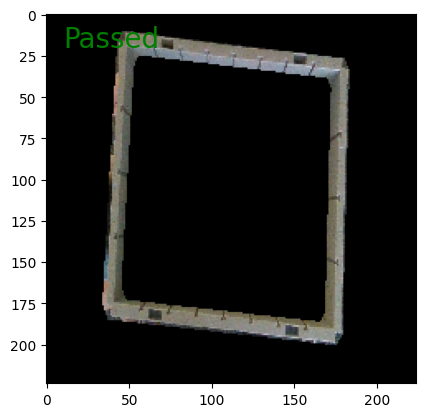

The image is classified as: Bincheck passed, expected result: Bincheck passed
1/1 [==============================] - 0s 29ms/step


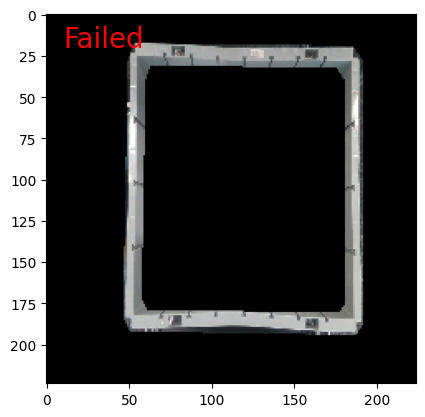

The image is classified as: Bincheck failed, expected result: Bincheck failed


In [ ]:
#train_dir = '../dataset_1111/factor12/'

def predict_image(img_path, model):
    img = image.load_img(img_path, target_size=(img_height, img_width))
   
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create batch axis
    img_array /= 255.0  # Normalize
    prediction = model.predict(img_array)

    plt.imshow(img)
    if  prediction[0] > 0.5:
        plt.text(x = 10, y = 20,s ='Passed', color = 'green', fontsize = 20)
    else:
        plt.text(x = 10, y = 20,s ='Failed', color = 'red', fontsize = 20)
    plt.show()
   
    return 'Bincheck passed' if prediction[0] > 0.5 else 'Bincheck failed'



# Example prediction
img_path = f'{train_dir}positive/positive_{np.random.randint(0,1000)}.jpg'
result = predict_image(img_path, model_inception)
print(f"The image is classified as: {result}, expected result: Bincheck passed")

img_path = f'{train_dir}negative/negative_{np.random.randint(0,1600)}.jpg'
result = predict_image(img_path, model_inception)
print(f"The image is classified as: {result}, expected result: Bincheck failed")